# MNIST 

In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import tqdm as tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import copy
import random
import time


def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm.tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')


def recon_train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y, z) in tqdm.tqdm(iterator, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)
        z = z.to(device)
        optimizer.zero_grad()
        x_pred = model(z)
        loss = criterion(x_pred, x)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def recon_evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for (x, y, z) in tqdm.tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)
            z = z.to(device)
            x_pred = model(z)
            loss = criterion(x, x_pred)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)


# Data preparation

In [3]:
ROOT = '.data'
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624
Number of training examples: 60000
Number of testing examples: 10000


some sample images

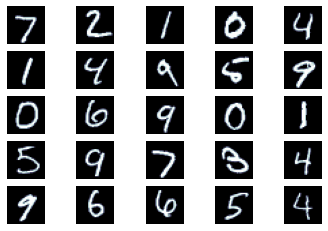

In [4]:
N_IMAGES = 25

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]

plot_images(images)

# Diffusion & Neural Nets

## Sampling 2D images

In [5]:
def sample_image2D(images, num_sampling):
    sampled_data = []
    for Im,label in tqdm.tqdm(images):
        im = Im[0]
        shape = im.shape
        im = im - im.min()
        im = im / im.sum()
        weights = torch.tensor(im.flatten(), dtype=torch.float) # create a tensor of weights
        samples = torch.multinomial(weights, num_sampling, replacement=True)
        samples_y, samples_x = np.unravel_index(samples, shape)
        X = np.array([samples_x,samples_y],np.float32)
        X = torch.tensor(X)
        X = X - X.mean()
        X = X / X.std()
        sampled_data.append((X,label,Im[0]))
    return sampled_data

SAMPLING= 200

train_sampled = sample_image2D(images=train_data, num_sampling=SAMPLING)
test_sampled = sample_image2D(images=test_data, num_sampling=SAMPLING)

  0%|                                                                                                 | 0/60000 [00:00<?, ?it/s]/tmp/ipykernel_3980523/1508837750.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(im.flatten(), dtype=torch.float) # create a tensor of weights
100%|███████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4374.91it/s]


## Random Encoder

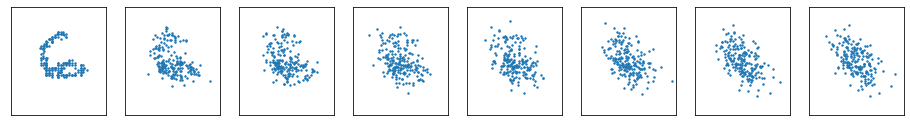

In [314]:

class MyMLP(nn.Module):
    def __init__(self, D, L, res):
        super().__init__()
        self.activ = F.relu
        self.fcs = [nn.Linear(D, D) for l in range(L)]
        for fc in self.fcs:
            # nn.init.xavier_normal_(w.weight,gain=1/np.sqrt(D))
            weights = torch.normal(0, 1.0/np.sqrt(D), size=fc.weight.shape)
            fc.weight.data = weights
        self.bns = [nn.BatchNorm1d(D) for l in range(L)]
        
        for li,(bn,fc) in enumerate(zip(self.bns,self.fcs)):
            self.add_module("fc_"+str(li), fc)
            self.add_module("bn_"+str(li), bn)
        self.L = L
        self.D = D
        self.res = res
        
    def layer_update(self, l,h):
        h2 = h
        h2 = self.activ(h2)
        h2 = self.fcs[l](h2)
        if l<len(self.fcs)-1:
            h2 = self.res * h + (1-self.res)*h2
        else:
            h2 = h
        h2 = my_layer_norm(h2)

        return h2


    def full_forward(self, h):
        shape = h.shape
        h = h.view(-1,h.shape[-1])
        h = my_layer_norm(h)
        H = [h.cpu().data.numpy()]
        for l in range(self.L):
            h = self.layer_update(l,h)
            H.append(h.view(shape).cpu().data.numpy())
        return H
    
    def forward(self, h):
        shape = h.shape
        h = h.view(-1,h.shape[-1])
        h = my_layer_norm(h)
        for l in range(self.L):
            h = self.layer_update(l,h)
        return h.view(shape)

    
def my_layer_norm(h):
    h = h - h.mean(-1,True)
    h = h / h.std(-1,keepdim=True)
    # h = h - h.mean()
    # h = h / h.std()
    return h


def show_layers(Hidden, Num=8,subplot=True,title=False,save_path=None):
    inds = np.linspace(1,len(Hidden)-1,num=Num,dtype=np.int32)
    Hidden = [Hidden[i] for i in inds]
    if subplot:
        fig = plt.figure(figsize=(2*Num,2))
    for Hi,(l,H) in enumerate(zip(inds,Hidden)):
        while H.shape[0]==1:
            H = H[0]
        # H = H.data.numpy()
        if subplot:
            ax = fig.add_subplot(1,8,Hi+1)
        else:
            plt.clf()
            ax = plt.gca()
        
        ax.scatter(H[0],-H[1],2)
        if title:
            ax.set_title(f'Layer = {Hi+1}')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(-4,4)
        ax.set_ylim(-4,4)
        if save_path:
            plt.savefig(f'{save_path}/{Hi}.png')
            


ENC_WIDTH = SAMPLING
ENC_LAYERS = 5000
ENC_RES = .98

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

randNet = MyMLP(L=ENC_LAYERS,D=ENC_WIDTH,res=ENC_RES)
randNet = randNet.to(device)

r = np.random.randint(len(train_sampled))
X, y,im = train_sampled[r]
X = torch.unsqueeze(X,0).to(device)
Hidden = randNet.full_forward(X)
show_layers(Hidden)

In [7]:
def get_encodings(iterator, model):
    batches = []
    for (x, y, im) in tqdm.tqdm(iterator, leave=False):
            x = x.to(device)
            y = y.to(device)
            z = model(x)
            x,y,z = x.cpu(),y.cpu(),z.cpu()
            
            batches.append((x.data,y.data,z.data,im.data))
    encodings = [(x,y,z) for batch in batches for (x,y,z,im) in zip(*batch)]
    return encodings


ENC_BATCH_SIZE = 256

train_iterator = data.DataLoader(train_sampled,batch_size=ENC_BATCH_SIZE)
test_iterator = data.DataLoader(test_sampled,batch_size=ENC_BATCH_SIZE)
            
train_encodes = get_encodings(iterator=train_iterator,model=randNet)
test_encodes = get_encodings(iterator=test_iterator,model=randNet)

## Decoder Net

In [9]:
class MyMLP2(nn.Module):
    def __init__(self, input_dim, D, OUTPUT_DIM, L, res):
        super().__init__()
        self.activ = torch.nn.functional.relu
        self.fcs = [nn.Linear(D, D) for l in range(L)]
        self.fcs[0] = nn.Linear(input_dim,D)
        self.fcs[-1] = nn.Linear(D,OUTPUT_DIM)
        for w in self.fcs:
            weights = torch.normal(0, 1.0/np.sqrt(D), size=w.weight.shape)
            w.weight.data = weights
        
        for li,layer in enumerate(self.fcs):
            self.add_module("hidden_layer_"+str(li), layer)
        self.L = L
        self.D = D
        self.res = res
        
    def layer_update(self, l,h):
        h2 = h
        h2 = self.activ(h2)
        h2 = self.fcs[l](h2)
        if l<len(self.fcs)-1:
            h2 = self.res * h + (1-self.res)*h2
        else:
            h2 = h
        h2 = my_layer_norm(h2)
        return h2


    def forward(self, h):
        shape = h.shape
        h = h.view(-1,h.shape[-1])

        for l in range(self.L):
            h = self.layer_update(l,h)
        return h.view(shape)
    

    def full_forward(self, h):
        shape = h.shape
        h = h.view(-1,h.shape[-1])
        h = my_layer_norm(h)
        H = [h.cpu().data.numpy()]
        for l in range(self.L):
            h = self.layer_update(l,h)
            H.append(h.view(shape).cpu().data.numpy())
        return H

LAYERS = 100
RES = .99 # 1 - 1.0/LAYERS
EPOCHS = 1000
BATCH_SIZE = 1024


INPUT_DIM = SAMPLING 
WIDTH = SAMPLING
OUTPUT_DIM = INPUT_DIM


train_iterator = data.DataLoader(train_encodes, shuffle=True, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_encodes, batch_size=BATCH_SIZE)

criterion = nn.MSELoss().to(device)
model = MyMLP2(INPUT_DIM, WIDTH,OUTPUT_DIM, LAYERS,RES).to(device)

Epoch: 0	Train Loss: 0.51775	 Val. Loss: 0.41435


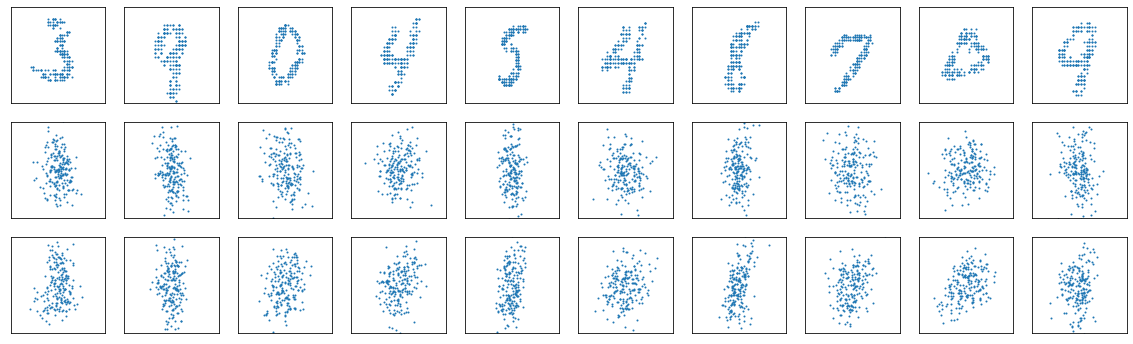

Epoch: 1	Train Loss: 0.32906	 Val. Loss: 0.27933


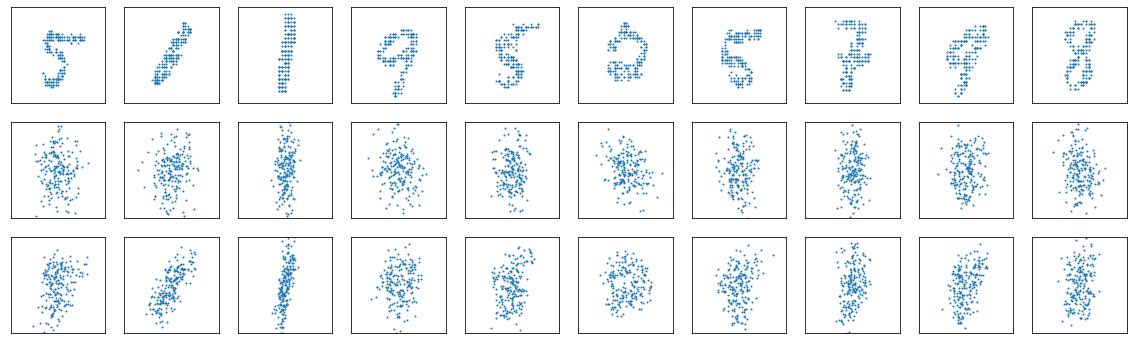

Epoch: 2	Train Loss: 0.22731	 Val. Loss: 0.19983


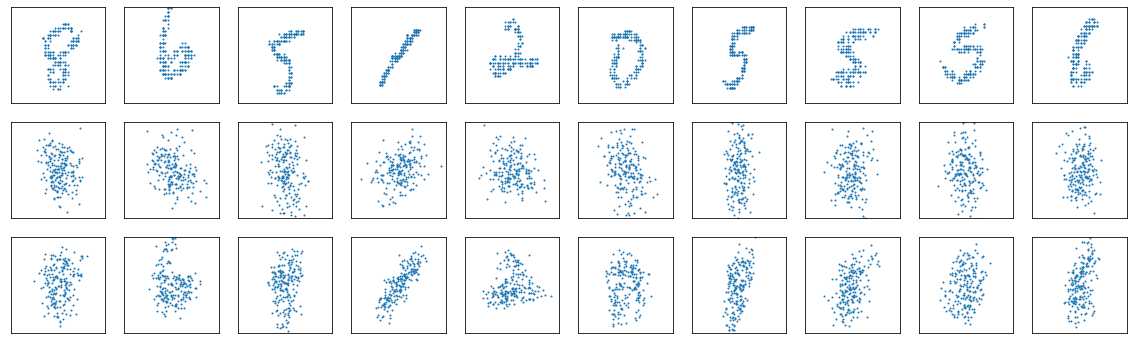

Epoch: 3	Train Loss: 0.16840	 Val. Loss: 0.15393


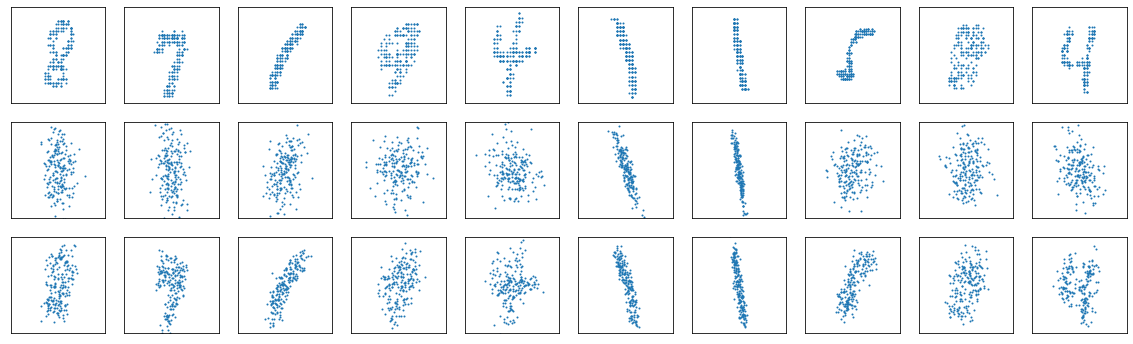

Epoch: 4	Train Loss: 0.13436	 Val. Loss: 0.12699


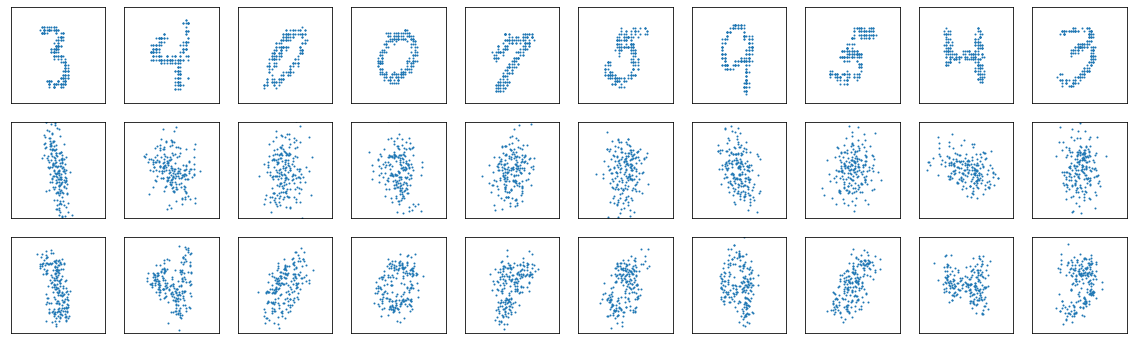

Epoch: 5	Train Loss: 0.11393	 Val. Loss: 0.11026


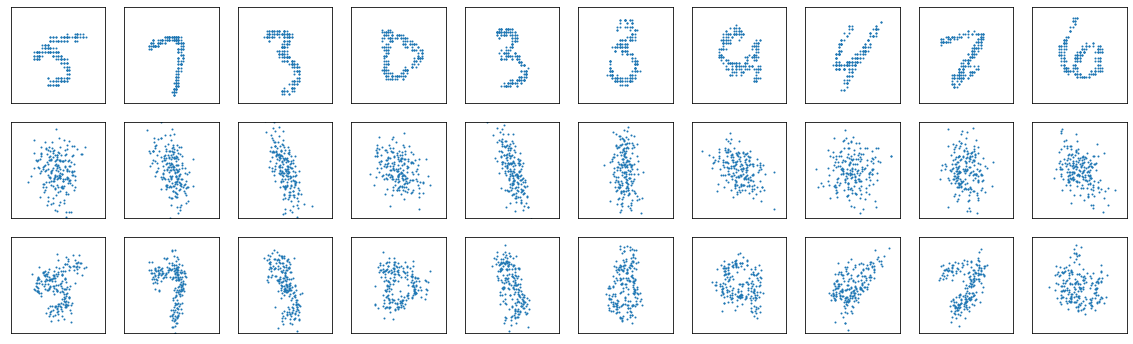

Epoch: 6	Train Loss: 0.10086	 Val. Loss: 0.09912


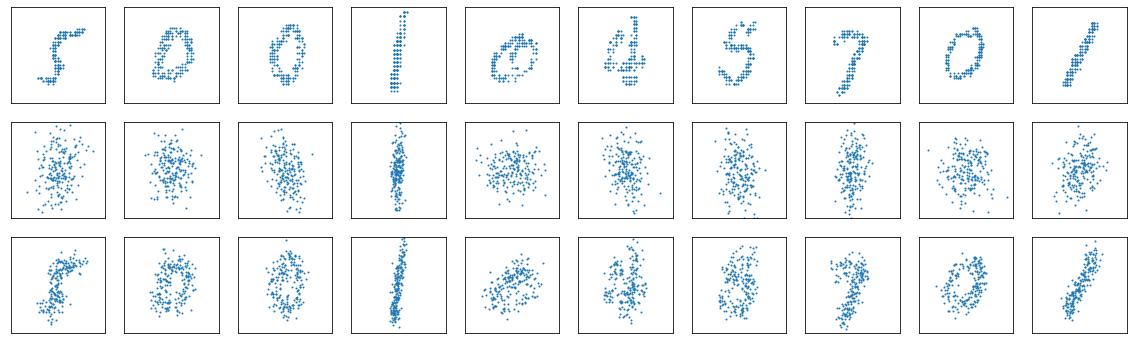

Epoch: 7	Train Loss: 0.09181	 Val. Loss: 0.09111


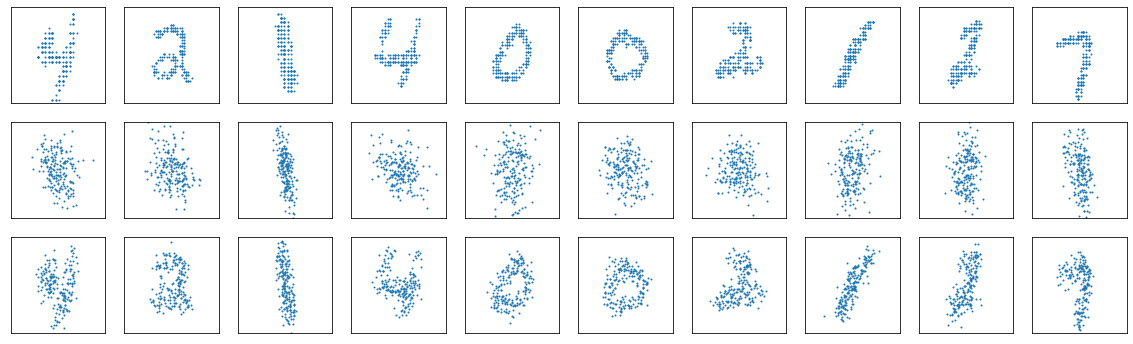

Epoch: 8	Train Loss: 0.08508	 Val. Loss: 0.08499


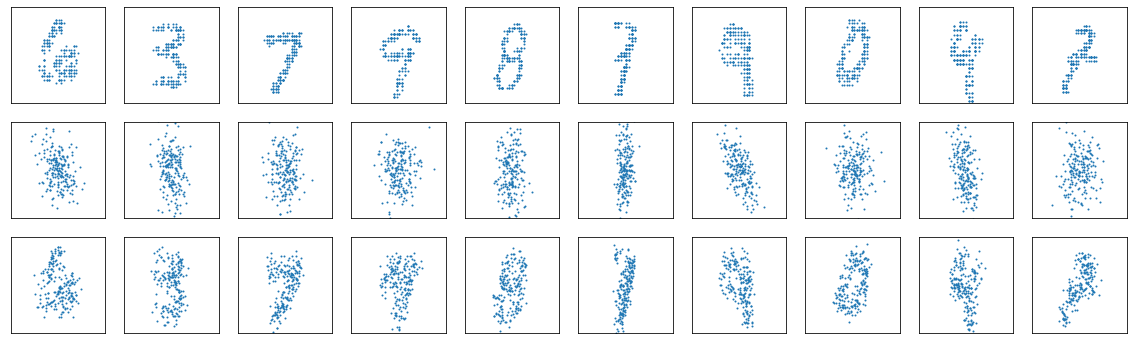

Epoch: 9	Train Loss: 0.07981	 Val. Loss: 0.08001


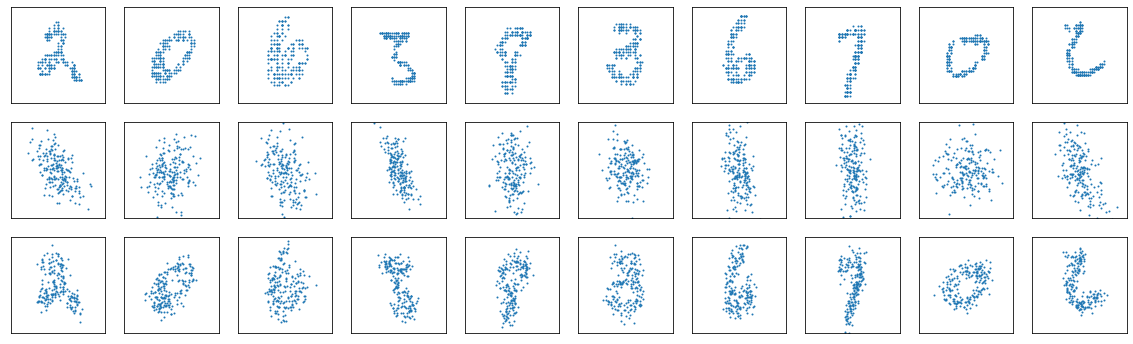

Epoch: 10	Train Loss: 0.07544	 Val. Loss: 0.07592


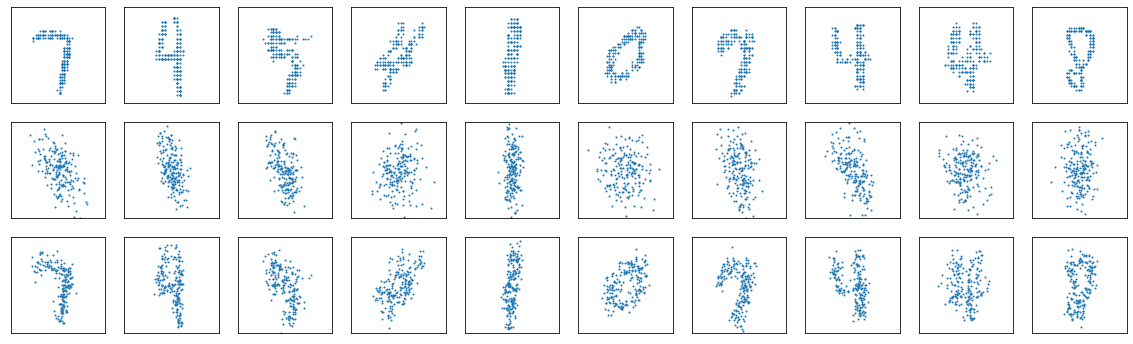

Epoch: 11	Train Loss: 0.07174	 Val. Loss: 0.07234


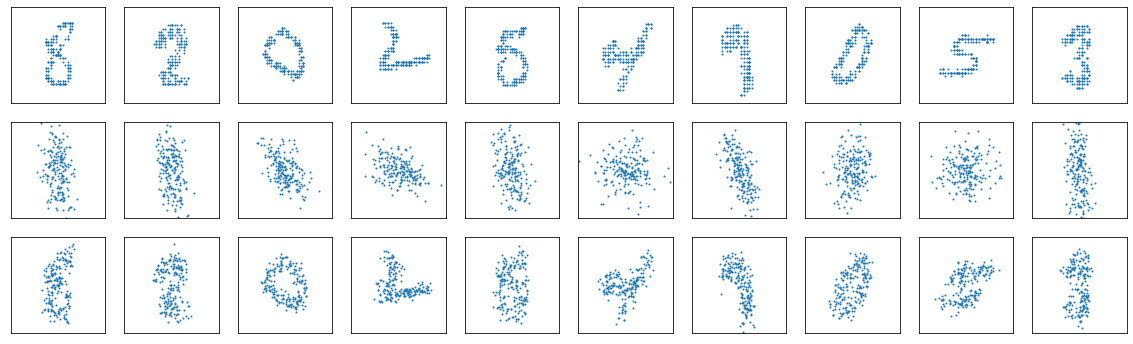

Epoch: 12	Train Loss: 0.06854	 Val. Loss: 0.06921


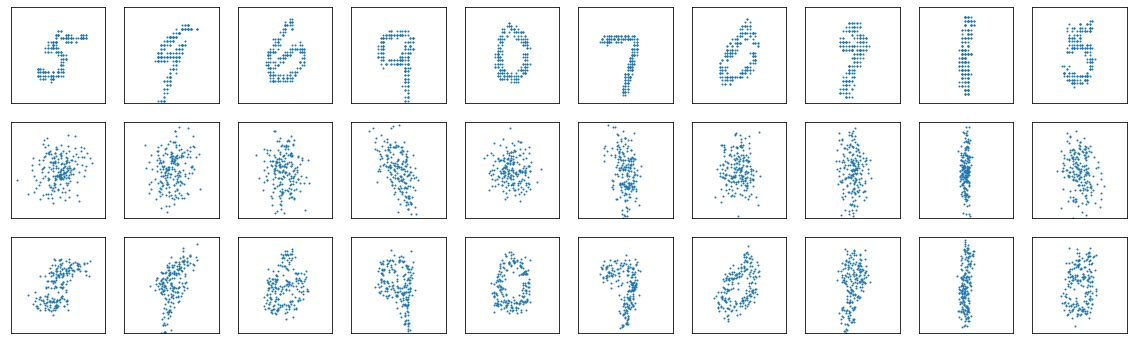

Epoch: 13	Train Loss: 0.06566	 Val. Loss: 0.06645


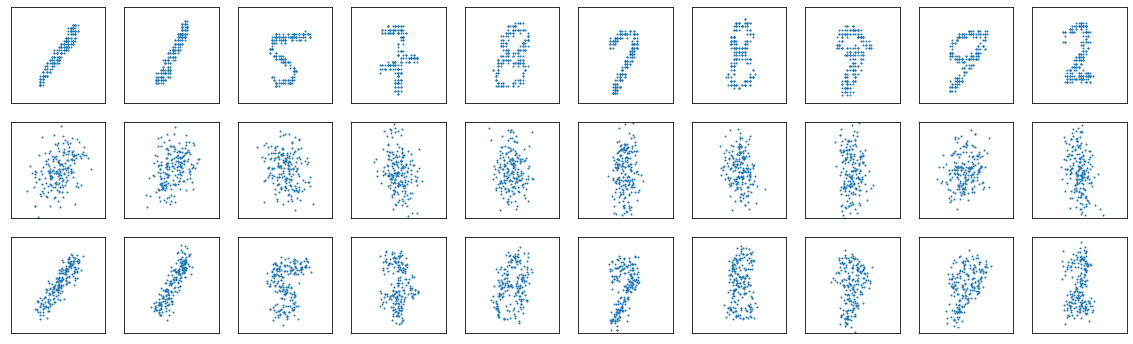

Epoch: 14	Train Loss: 0.06315	 Val. Loss: 0.06401


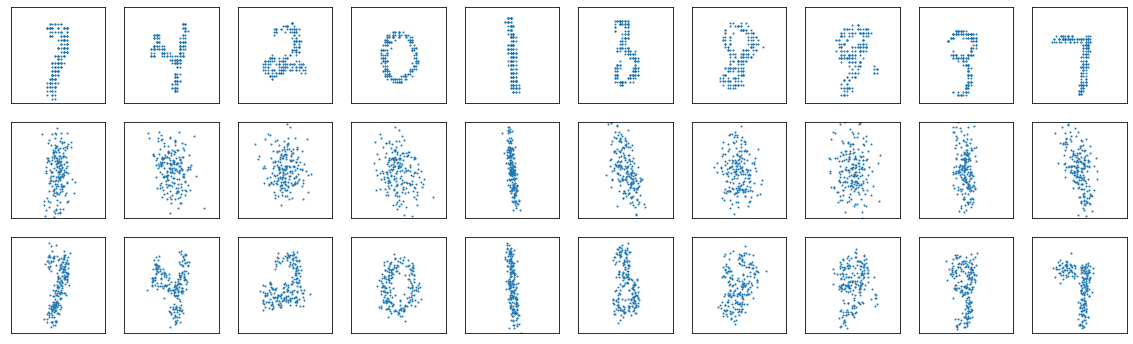

Epoch: 15	Train Loss: 0.06086	 Val. Loss: 0.06175


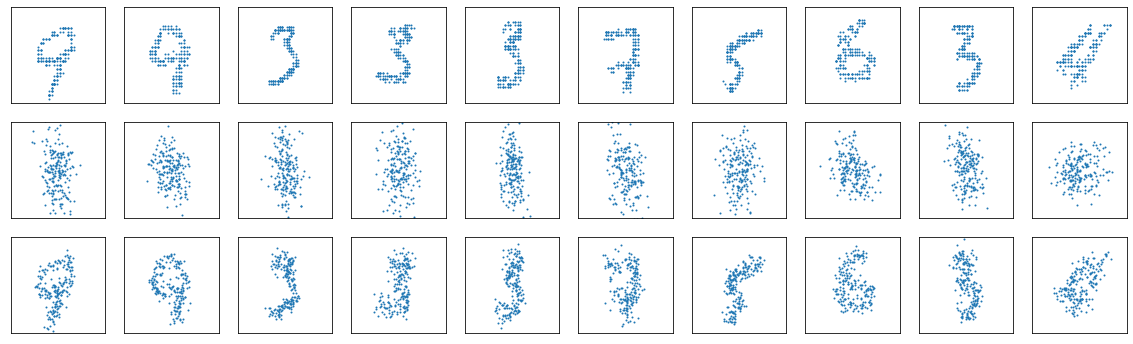

Epoch: 16	Train Loss: 0.05878	 Val. Loss: 0.05970


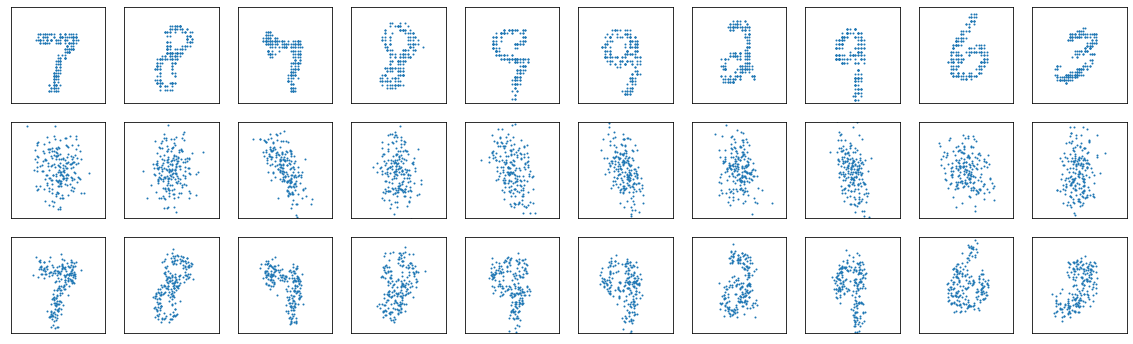

Epoch: 17	Train Loss: 0.05685	 Val. Loss: 0.05777


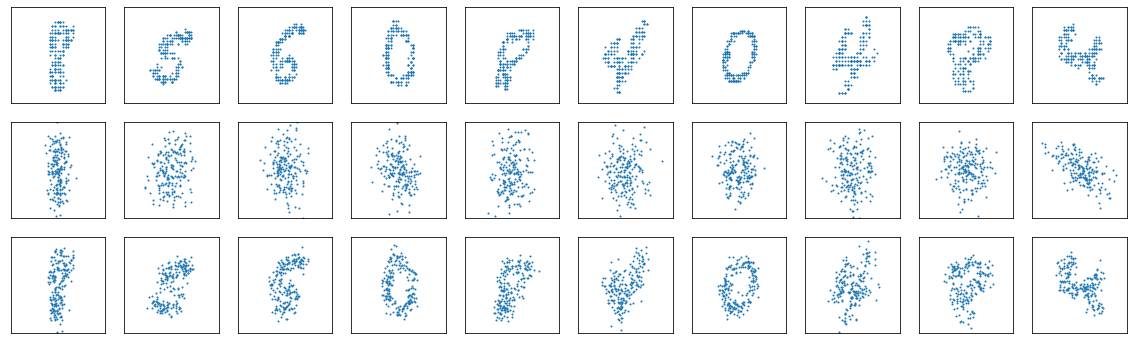

Epoch: 18	Train Loss: 0.05510	 Val. Loss: 0.05607


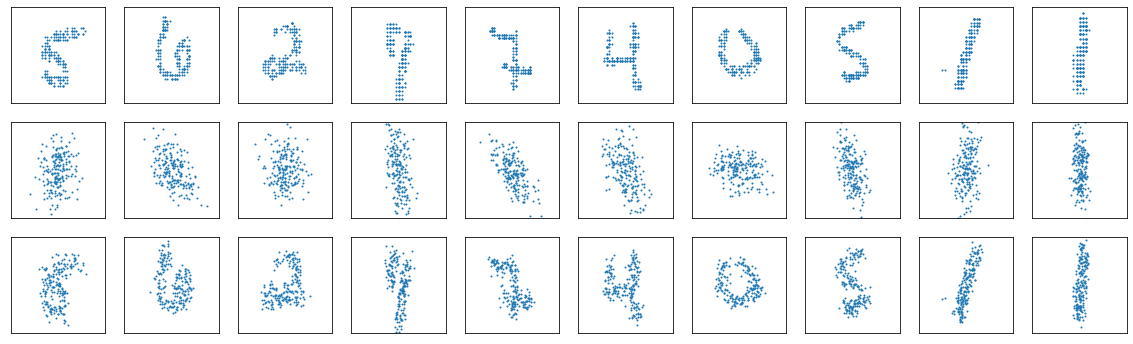

Epoch: 19	Train Loss: 0.05352	 Val. Loss: 0.05451


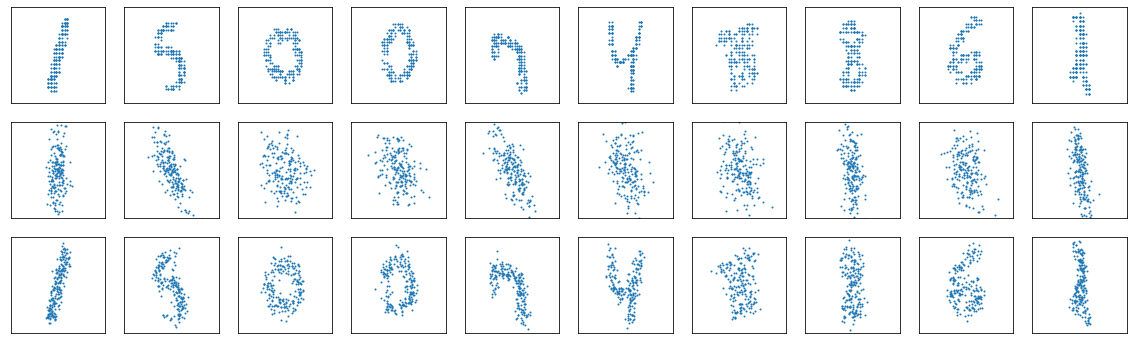

Epoch: 20	Train Loss: 0.05201	 Val. Loss: 0.05302


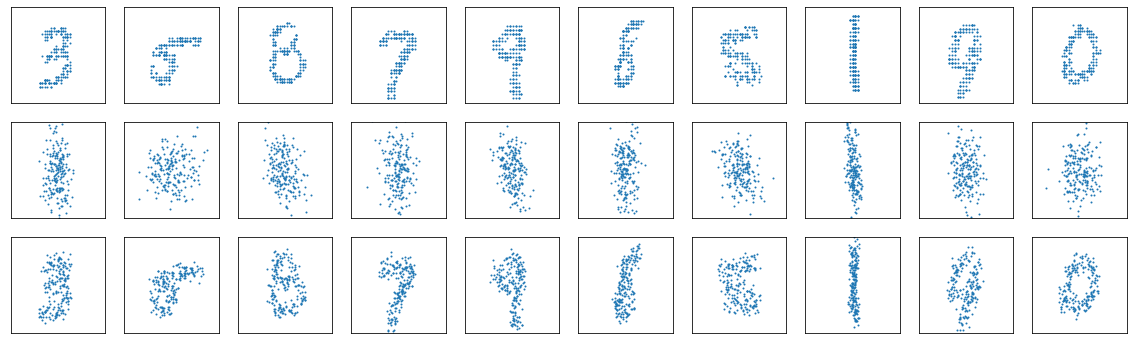

Epoch: 21	Train Loss: 0.05065	 Val. Loss: 0.05161


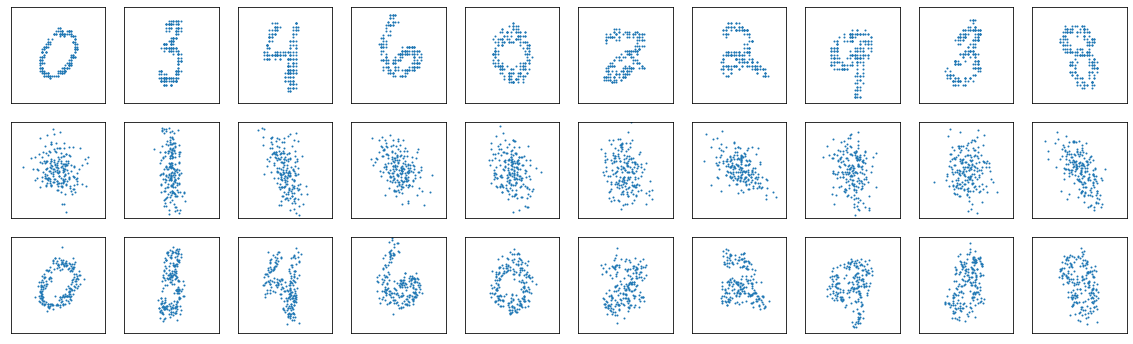

Epoch: 22	Train Loss: 0.04936	 Val. Loss: 0.05042


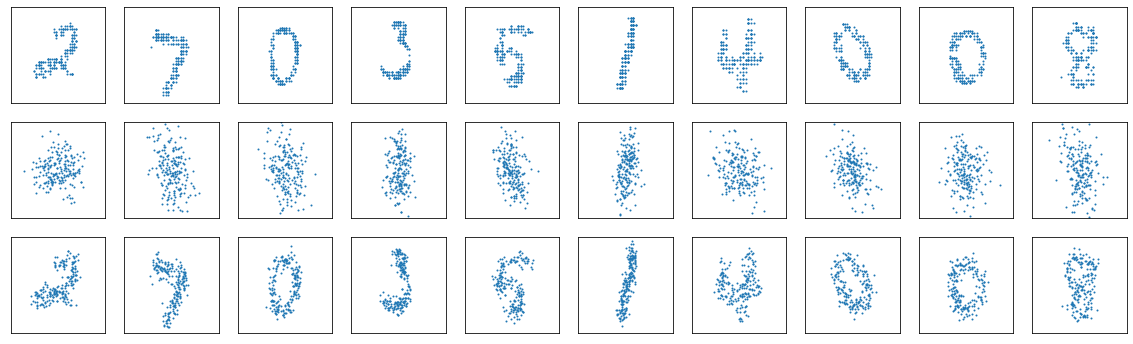

Epoch: 23	Train Loss: 0.04819	 Val. Loss: 0.04922


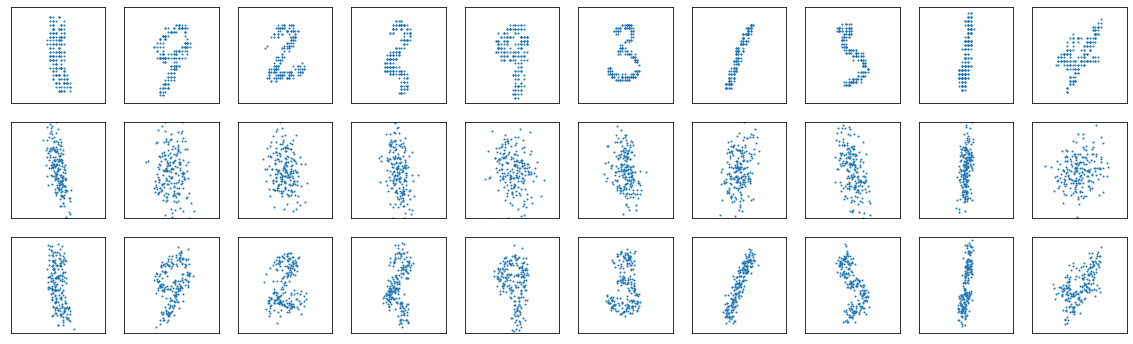

Epoch: 24	Train Loss: 0.04707	 Val. Loss: 0.04808


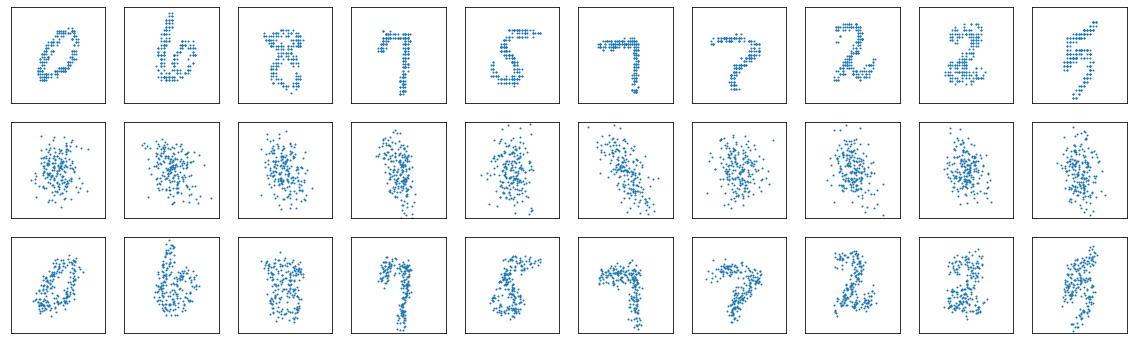

Epoch: 25	Train Loss: 0.04602	 Val. Loss: 0.04703


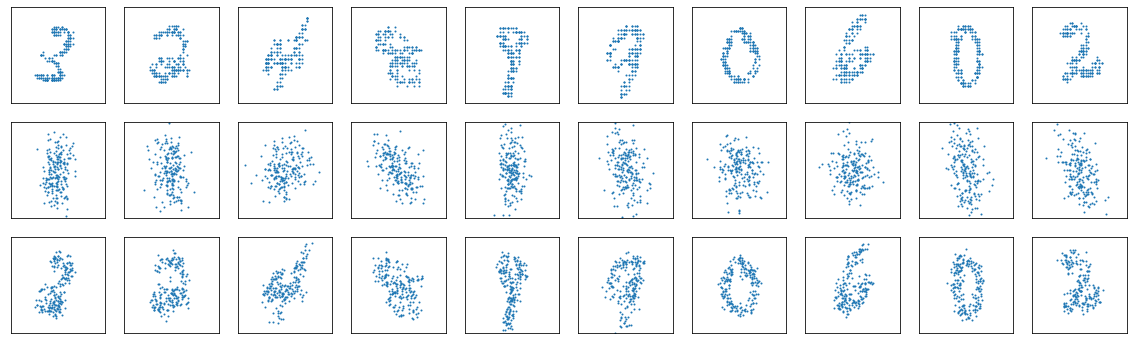

Epoch: 26	Train Loss: 0.04505	 Val. Loss: 0.04608


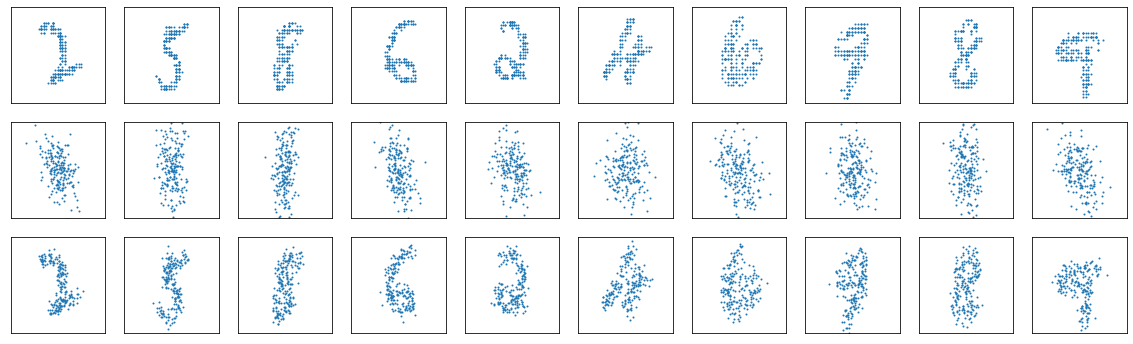

Epoch: 27	Train Loss: 0.04413	 Val. Loss: 0.04518


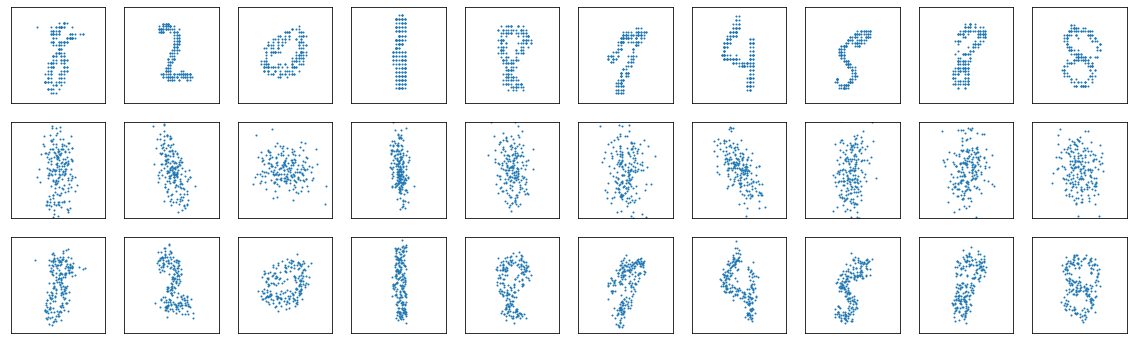

Epoch: 28	Train Loss: 0.04328	 Val. Loss: 0.04431


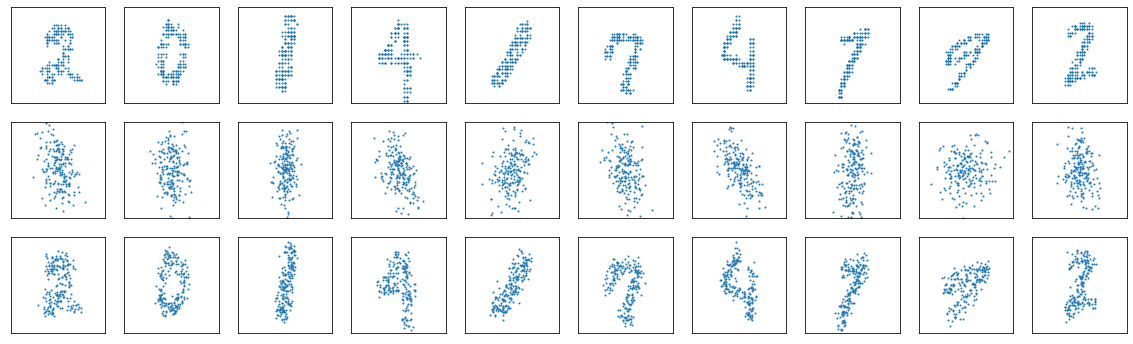

Epoch: 29	Train Loss: 0.04245	 Val. Loss: 0.04349


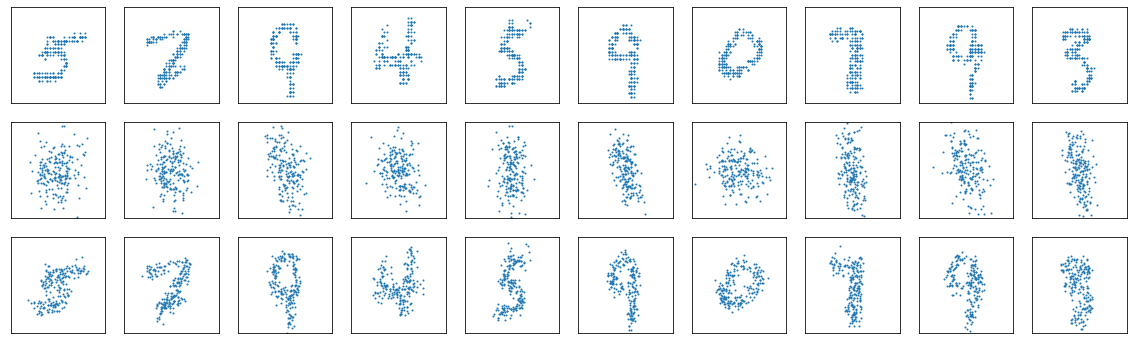

Epoch: 30	Train Loss: 0.04165	 Val. Loss: 0.04270


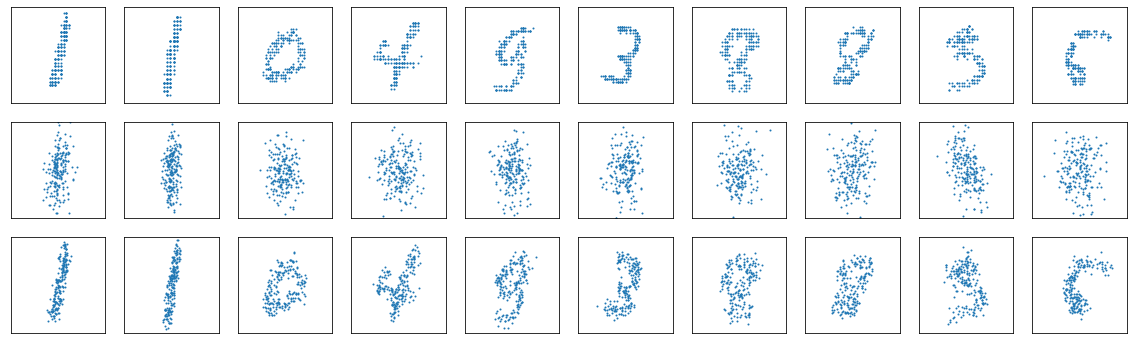

KeyboardInterrupt: 

In [10]:
        
def sample_plot(Repeat=5, W=2, KDE=False):
    for param in model.parameters():
        param.requires_grad = False
    fig, axes = plt.subplots(3, Repeat,figsize=(Repeat*W,3*W))
    for ai in range(Repeat):
        X,_,Z = test_encodes[np.random.randint(len(test_encodes))]
        Z = Z.view(2,-1)
        X_pred = model(torch.unsqueeze(Z,0).to(device))
        X_pred = X_pred.view(2,-1).cpu().data
        X = X.cpu().data.numpy()
        for aj,A in enumerate([X,Z,X_pred]):
            ax = axes[aj][ai]
            if KDE:
                sns.kdeplot(ax=ax,x=A[0],y=-A[1],fill=True,bw_adjust=.5)
            else:
                ax.scatter(A[0],-A[1],1)
            ax.set_xlim(-4,4)
            ax.set_ylim(-3,3)
            ax.set_xticks([])
            ax.set_yticks([])

    for param in model.parameters():
        param.requires_grad = True
    fig.show()
    plt.savefig(f'fig{int(KDE)}.png')
    

best_valid_loss = float('inf')
optimizer = optim.Adam(model.parameters())
for epoch in range(EPOCHS):
    train_loss = recon_train(model, train_iterator, optimizer, criterion, device)
    valid_loss = recon_evaluate(model, test_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    print(f'Epoch: {epoch}\tTrain Loss: {train_loss:.5f}\t Val. Loss: {valid_loss:.5f}')
    sample_plot(10,2)
    plt.show()

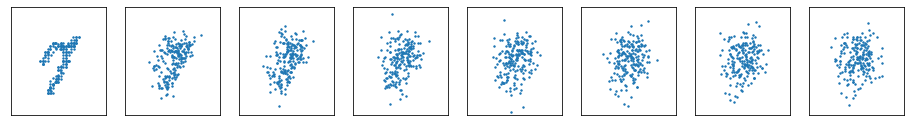

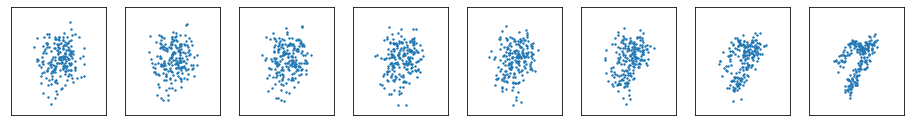

In [24]:


X,_,_ = test_encodes[np.random.randint(len(test_encodes))]

Hidden = randNet.full_forward(torch.unsqueeze(X,0).to(device))
Z = torch.tensor(Hidden[-1])
Hidden2 = model.full_forward(torch.unsqueeze(Z,0).to(device))

show_layers(Hidden, Num=8)
show_layers(Hidden2, Num=8)


In [81]:
import glob
from PIL import Image

!rm images/*

show_layers(Hidden+Hidden2, Num=40,save_path='images',subplot=False)

# filepaths
fp_in = "./images/*.png"
fp_out = "image.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
imgs = glob.glob(fp_in)
idx = np.argsort([int(f.split('/')[-1].split('.')[0]) for f in imgs])
imgs = [imgs[i] for i in idx]
imgs = (Image.open(f) for f in imgs)
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=300, loop=0)

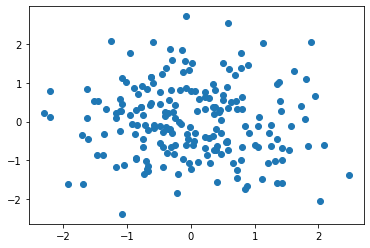

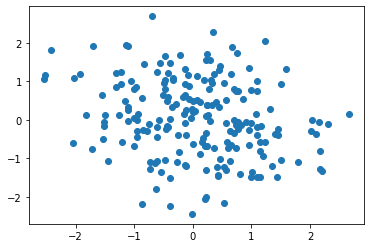

In [30]:
Z2 = torch.normal(mean=0,std=1,size=Z.shape) 

X2 = model.forward(torch.unsqueeze(Z2,0).to(device))
X2 = X2.cpu().data.numpy()
X2 = X2[0,0]
plt.scatter(Z2[0,0],Z2[0,1])
plt.figure()
plt.scatter(X2[0],-X2[1])

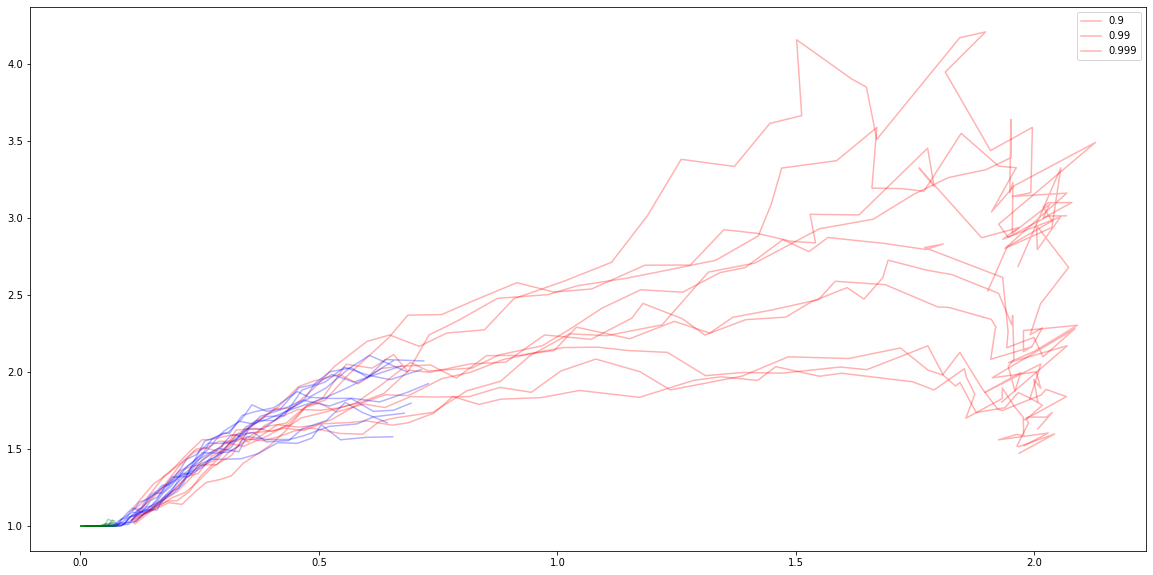

In [377]:
def W2opt(xs,xt):
    assert(len(xs)==len(xt))
    M = euclidean_distances(xs,xt) ** 2
    n = len(xs)
    a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples
    G0 = ot.emd(a, b, M)    
    d_opt = np.multiply(M,G0).sum()
    
    G1= np.eye(G0.shape[0]) 
    G1 = G1 / np.sum(G1) * np.sum(G0)
    d = np.multiply(M,G1).sum()
    
    # print(f'{d/d_opt:.5f}')
    return np.sqrt(d),np.sqrt(d_opt)

def point_optimality(H,c):
    Ds,Ds2 = [],[]
    layers = np.linspace(0,np.log2(len(H)-2))
    layers = 2**layers
    layers = layers.astype(np.int32)
    for i in layers:
        d1,d2 = W2opt(H[0],H[i])
        Ds.append(d1)
        Ds2.append(d1/d2)
        
    # plt.figure()
    plt.plot(Ds,Ds2,c,alpha=.3,)
    # plt.figure()
    # plt.plot(layers,Ds)
    # plt.title(f'optiamility vs layer',fontsize=12)
    # plt.xlabel('layer $\ell$')
    # plt.ylabel('optimality')
    # plt.savefig('optimality.png')
    
# net = MyMLP(L=5000,D=ENC_WIDTH,res=0.99)
# X,_,_ = test_encodes[np.random.randint(len(test_encodes))]
# H = net.full_forward(torch.unsqueeze(X,0))
# # show_layers(H)
# H = fix_hidden(H)
# point_optimality(H)

plt.figure(figsize=(20,10))
residuals = [.9,.99]
for res,c in zip(residuals,['r','b','g','y']):
    net = MyMLP(L=5000,D=ENC_WIDTH,res=res)
    for i in range(10):
        X,_,_ = test_encodes[np.random.randint(len(test_encodes))]
        H = net.full_forward(torch.unsqueeze(X,0))
        # show_layers(H)
        H = fix_hidden(H)
        point_optimality(H,c)
    # plt.title(f'res = {res}')
    # plt.show()
plt.legend(residuals)

In [367]:
layers = np.linspace(0,np.log(len(H)-1))
layers = np.exp(layers).astype(np.int32)
layers

array([  1,   1,   1,   1,   1,   1,   1,   1,   2,   2,   2,   2,   3,
         3,   3,   4,   4,   4,   5,   5,   6,   7,   7,   8,   9,  10,
        11,  12,  13,  15,  16,  18,  20,  22,  24,  26,  29,  32,  35,
        39,  42,  47,  51,  56,  62,  68,  75,  82,  91, 100], dtype=int32)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 174.42it/s]


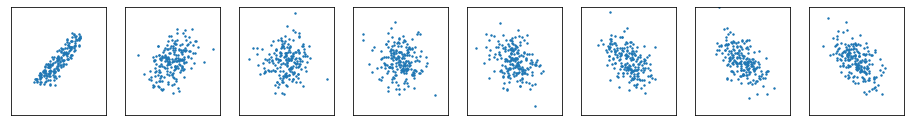

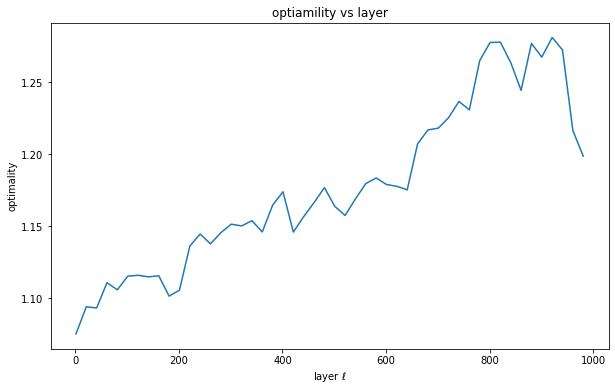

In [299]:
import ot
import ot.plot
from sklearn.metrics.pairwise import euclidean_distances

def W2dist(xs,xt):
    # M = ot.dist(xs, xt)
    M = euclidean_distances(xs,xt) ** 2

    n = len(xs)
    assert(len(xs)==len(xt))
    a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples
    G0 = ot.emd(a, b, M)
    d = np.multiply(M,G0).sum()
    return  np.sqrt(d)

def layers_optimality(H):
    D = W2dist(H[0],H[-1])
    Ds = []
    layers = range(1,len(H),20)
    for i in tqdm.tqdm(layers):
        d1 = W2dist(H[0],H[i])
        d2 = W2dist(H[i],H[-1])
        Ds.append((d1+d2)/D)

    plt.figure(figsize=(10,6))
    plt.plot(layers,Ds)
    plt.title(f'optiamility vs layer',fontsize=12)
    plt.xlabel('layer $\ell$')
    plt.ylabel('optimality')
    plt.savefig('optimality.png')
    
    
def fix_hidden(H0):
    H = []
    for i in range(len(H0)):
        if H0[i].shape[0] == 1:
            H.append(H0[i][0].transpose())
        else:
            H.append(H0[i].transpose())
    return H


X,_,_ = test_encodes[np.random.randint(len(test_encodes))]

net = MyMLP(L=1000,D=ENC_WIDTH,res=0.90)
H = net.full_forward(torch.unsqueeze(X,0))
show_layers(H)
H = fix_hidden(H)
layers_optimality(H)

In [280]:
xs, xt = H[0],H[1]



7.841926
7.8419266


(200, 200)